In [2]:
% clear
%pylab inline
import h5py
import os
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [3]:
# It loads the pulse energy values (expressed in mJ) of each event
with h5py.File("/scratch/fhgfs/alberto/test/gmd.h5",'r') as f:
    gmd = f['/cheetah/event_data/gmd1/'][:]

# It loads the log-likelihood scores obtained by running 'hitfinding.py' script
with h5py.File("/scratch/fhgfs/alberto/test/baglivo_score.h5",'r') as f:
    baglivo = f['data'][:]

# It retrieves the indices of the preliminary misses calculated as explained in the paper (see documentation)    
with h5py.File("/scratch/fhgfs/alberto/test/photon_space_frames_column.h5",'r') as f:
    misses_ind = f['indices1'][:].astype('bool')

# It loads the fitted (expected) and real photon counts for each event    
with h5py.File("/scratch/fhgfs/alberto/test/photon_space_frames_column.h5",'r') as f:
    fittedphc = f['fitv_sample'][:]
    realphc = f['photon_count_per_frame'][:]

In [4]:
# Pulse energies, log-likelihood scores, fitted and real values 
# of the preliminary misses that are treated as backgound.
# The set of preliminary misses is a subset of all the events of the run considered.
gmd_misses = gmd[misses_ind]
bag_misses = baglivo[misses_ind]    
fittedphc_misses = fittedphc[misses_ind]
realphc_misses = realphc[misses_ind]

In [5]:
# It excludes blank/weird events according to certain conditions
# and then return the indices of the "good" and desirable events
def exclude_events(realphc,gmd,bscore):
    index = (realphc>400)*(gmd>1)*(bscore>1)
    return index

# Function to normalize the scores through a simple linear fitting
def normalize_scores(fittedphc_bkg,baglivo_bkg,fitphc,bscore,ib,ii):
    linfit = polyfit(fittedphc_bkg[ib],baglivo_bkg[ib],1)
    x_values_bag = linfit[0]*fitphc + linfit[1]
    y_norm = bscore[ii] - x_values_bag[ii]
    return y_norm, fitphc[ii]

In [6]:
# Blank events are excluded from both the sets: the background (misses) and the sample one 
ii_tot = exclude_events(realphc,gmd,baglivo)
ii_b = exclude_events(realphc_misses,gmd_misses,bag_misses)

# Normalized values of the log-likelihood scores are obtained
# for the background set (or preliminary misses)
# and for the superset of all the events
Y_BKG, X_BKG = normalize_scores(fittedphc_misses,bag_misses,fittedphc_misses,bag_misses,ii_b,ii_b)
Y_TOT, X_TOT = normalize_scores(fittedphc_misses,bag_misses,fittedphc,baglivo,ii_b,ii_tot)

# A threshold is defined
thr = Y_BKG[X_BKG>400].mean() + 4*Y_BKG[X_BKG>400].std()

False Positive rate 0.0235804565176 %


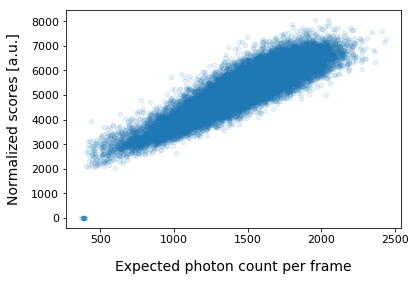

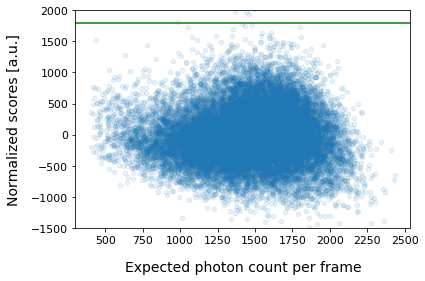

In [9]:
# Figure of the log-likelihood scores for the background set
figure()
scatter(fittedphc_misses,bag_misses,alpha=0.1,s=20)
xlabel(r'Expected photon count per frame',fontsize=14, labelpad=15) 
ylabel(r'Normalized scores [a.u.]',fontsize=14, labelpad=10)
tick_params(labelsize=11)

# Figure of the normalized background values
figure()
scatter(X_BKG,Y_BKG,alpha=0.1,s=20)
xlabel(r'Expected photon count per frame',fontsize=14, labelpad=15) 
ylabel(r'Normalized scores [a.u.]',fontsize=14, labelpad=10)
tick_params(labelsize=11)
ylim([-1500,2000])
axhline(thr,color='green')

print "False Positive rate",(100*Y_BKG[Y_BKG>thr].shape[0]/float(Y_BKG.shape[0])),"%"